In [1]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
from skimage.morphology import skeletonize
import itertools
from collections import defaultdict


In [2]:
IMG_PATH = "C:/programmering/DTU/robobot/data/blob/blob2.jpg"
CM_PATH = 'C:/programmering/DTU/robobot/config/camera/calibration_matrix.npy'
DIST_PATH = 'C:/programmering/DTU/robobot/config/camera/distortion_coefficients.npy'

In [3]:
mtx = np.load(CM_PATH)
dist = np.load(DIST_PATH)

In [4]:

def plot_mask(mask, title):
    if isinstance(mask, list):
        for i in range(len(mask)):
            plt.subplot(1, len(mask), i+1)
            plt.imshow(mask[i], cmap='gray')
            plt.title(title[i])
            plt.axis('off')
    else:
        plt.imshow(mask, cmap='gray')
        plt.title(title)
        plt.axis('off')
    plt.show()

In [5]:
def get_blue_mask(hsv):
    BLUE_MIN = np.array([100,0,150])
    BLUE_MAX = np.array([150,255,255])
    
    mask = cv2.inRange(hsv, BLUE_MIN, BLUE_MAX)
    
    mask = cv2.erode(mask, None, iterations=5)
    mask = cv2.dilate(mask, None, iterations=5)
    return mask

def get_red_mask(hsv):
    # Adjusted RED_MIN and RED_MAX to cover the red hue range
    RED_MIN1 = np.array([0, 50, 50])  # Lower range of red
    RED_MAX1 = np.array([10, 255, 255])
    RED_MIN2 = np.array([170, 50, 50])  # Upper range of red
    RED_MAX2 = np.array([180, 255, 255])

    # Create masks for both red ranges and combine them
    mask1 = cv2.inRange(hsv, RED_MIN1, RED_MAX1)
    mask2 = cv2.inRange(hsv, RED_MIN2, RED_MAX2)
    mask = cv2.bitwise_or(mask1, mask2)
    
    mask = cv2.erode(mask, None, iterations=5)
    mask = cv2.dilate(mask, None, iterations=5)
    return mask

def get_white_mask(hsv):
    white_mask = cv2.inRange(hsv, (0, 0, 200), (180, 20, 255))
    white_mask = cv2.erode(white_mask, None, iterations=5)
    white_mask = cv2.dilate(white_mask, None, iterations=5)
    
    # Set up the SimpleBlobDetector parameters.
    params = cv2.SimpleBlobDetector_Params()

    # Filter by Area.
    params.filterByArea = False
    params.minArea = 150

    # Filter by Circularity
    params.filterByCircularity = True
    params.minCircularity = 0.1

    # Filter by Convexity
    params.filterByConvexity = False
    params.minConvexity = 0.87

    # Filter by Inertia
    params.filterByInertia = False
    params.minInertiaRatio = 0.01

    # Create a detector with the parameters
    detector = cv2.SimpleBlobDetector_create(params)

    # Detect blobs in the white mask
    keypoints = detector.detect(white_mask)

    # Draw detected blobs as red circles.
    im_with_keypoints = cv2.drawKeypoints(white_mask, keypoints, np.array([]), (0, 0, 255), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    print(keypoints)
    # Display the result
    plt.imshow(im_with_keypoints, cmap='gray')
    plt.title("Blobs Detected")
    plt.axis('off')
    plt.show()
    return white_mask
    

(< cv2.KeyPoint 00000220458A0420>, < cv2.KeyPoint 00000220458A2EB0>)


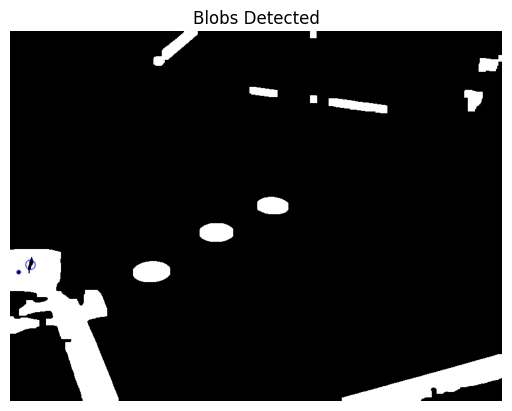

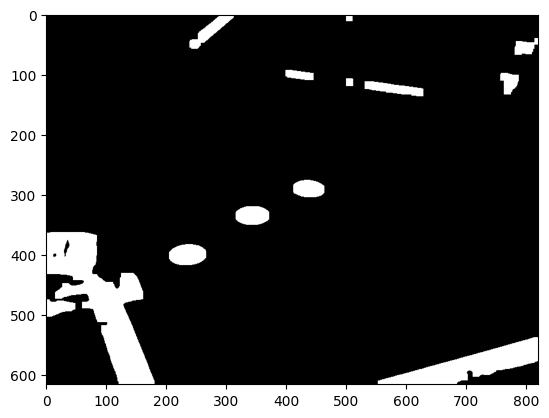

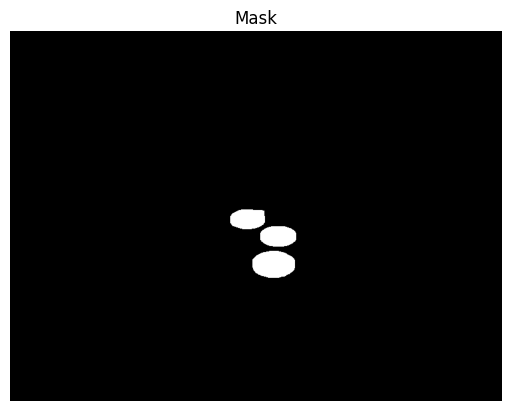

In [6]:
img = cv2.imread(IMG_PATH)
img = cv2.resize(img, (820, 616))

blurred = cv2.GaussianBlur(img, (11, 11), 0)

hsv = cv2.cvtColor(blurred, cv2.COLOR_BGR2HSV)

# hsv_crop = hsv[370:405,410:470]

blue_mask = get_blue_mask(hsv)
red_mask = get_red_mask(hsv)
white_mask = get_white_mask(hsv)

plt.imshow(white_mask, cmap='gray')
plt.show()

#Combine masks
mask = cv2.bitwise_or(blue_mask, red_mask)

plot_mask(mask, 'Mask')